#### Modelo para predecir el precio

En esta sección se presenta un modelo de Machine Learning para predecir el precio. Al ser el objetivo final la predicción, se hace foco en la precisión, no tanto en la interpretabilidad y/o inferencia.

In [70]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import ExtraTreesRegressor 

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(0)

listings_completo = pd.read_csv('dataset_nuevo/listings.csv.gz',compression='gzip',low_memory=False)
listings_completo_copy = listings_completo.copy()

Se toman las variables que tienen al menos el 70% de los datos.

In [71]:
nulos = pd.DataFrame(listings_completo.isnull().sum().sort_values(ascending=False),columns=['q_nulos'])
nulos['q_porc'] = (nulos['q_nulos'] / len(listings_completo))*100
variables = nulos[nulos['q_porc'] <= 30]
listings_filt = listings_completo[variables.index.to_list()]
listings_filt_variables = pd.DataFrame(listings_filt.dtypes,columns=['Tipo_var'])

Se acomodan los datos

 - Limpiamos los outliers podando el 2.5% de los precios más altos y más bajos.
 - Se acomodan formatos de distintas variables (fecha, numéricas, etc).
 - Para los datos de fecha se calculan las diferencias.
 
Se analizaron las variables una a una y me quedo con las variables que, conociendo el problema, hacen sentido a la solución

In [72]:

listings_filt["price"] = listings_filt["price"].str.replace("$", "" ,regex=True)
listings_filt["price"] = listings_filt["price"].str.replace("(.{3}$)", "" ,regex=True)
listings_filt["price"] = listings_filt["price"].str.replace(",", "" ,regex=True)
listings_filt["price"] = pd.to_numeric(listings_filt["price"])

q_low = listings_filt["price"].quantile(0.025)
q_hi  = listings_filt["price"].quantile(0.975)
listings_variables = listings_filt[(listings_filt["price"] < q_hi) & (listings_filt["price"] > q_low)]

listings_filt["cleaning_fee"] = listings_filt["cleaning_fee"].str.replace("$", "" ,regex=True)
listings_filt["cleaning_fee"] = pd.to_numeric(listings_filt["cleaning_fee"])

listings_filt["host_response_rate"] = listings_filt["host_response_rate"].str.replace("%", "" ,regex=True)
listings_filt["host_response_rate"] = pd.to_numeric(listings_filt["host_response_rate"])

listings_filt['host_since'] = pd.to_datetime(listings_filt['host_since'])
listings_filt['first_review'] = pd.to_datetime(listings_filt['first_review'])
listings_filt['last_review'] = pd.to_datetime(listings_filt['last_review'])

listings_filt['antig_host'] = (pd.to_datetime('today').normalize() - listings_filt['host_since']).dt.days
listings_filt['first_review_since'] = (pd.to_datetime('today').normalize() - listings_filt['first_review']).dt.days
listings_filt['last_review_since']  = (pd.to_datetime('today').normalize() - listings_filt['last_review']).dt.days
listings_filt['dif_last_first_review'] = (listings_filt['last_review'] - listings_filt['first_review']).dt.days

listings_filt["extra_people"] = listings_filt["extra_people"].str.replace("$", "" ,regex=True)
listings_filt["extra_people"] = pd.to_numeric(listings_filt["extra_people"])

listings_filt.drop(['latitude','longitude','scrape_id','host_id','last_review','summary', 'calendar_updated','first_review','host_since', 'space', 'description', 'zipcode', 'state', 'host_location', 'market', 'host_thumbnail_url', 'host_name', 'host_picture_url','city','name', 'calendar_last_scraped','last_scraped','experiences_offered','picture_url', 'host_url', 'host_verifications', 'street', 'smart_location', 'country_code', 'country','listing_url','amenities'], axis=1,inplace=True)

# reordeno alas variables
listings_filt = listings_filt[['id','price','cleaning_fee', 'host_response_time', 'host_response_rate','review_scores_value', 'review_scores_accuracy','review_scores_location', 'review_scores_rating','review_scores_cleanliness', 'review_scores_communication','review_scores_checkin', 'host_neighbourhood', 'reviews_per_month','beds', 'neighbourhood', 'host_identity_verified', 'host_is_superhost','host_has_profile_pic', 'host_total_listings_count','host_listings_count', 'bedrooms', 'bathrooms', 'availability_90','availability_60', 'availability_30', 'has_availability','availability_365', 'number_of_reviews','calculated_host_listings_count_shared_rooms','calculated_host_listings_count_private_rooms','require_guest_profile_picture','calculated_host_listings_count_entire_homes', 'number_of_reviews_ltm','calculated_host_listings_count', 'require_guest_phone_verification','instant_bookable', 'cancellation_policy', 'requires_license','maximum_nights_avg_ntm', 'is_business_travel_ready','minimum_nights_avg_ntm', 'maximum_maximum_nights','neighbourhood_cleansed', 'neighbourhood_group_cleansed','is_location_exact', 'property_type', 'room_type', 'bed_type','guests_included', 'extra_people', 'minimum_nights', 'maximum_nights','minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'accommodates', 'antig_host','first_review_since', 'last_review_since', 'dif_last_first_review']]

Eliminamos los datos nulos y mediante one hot encoding se acomodan las variables cualitativas.

In [73]:
listings_filt_bis = listings_filt.dropna()

listings_filt2 = listings_filt_bis.copy()
listings_filt2.drop('id',axis=1,inplace=True)
listings_filt2=pd.get_dummies(listings_filt2,drop_first=True)

y = listings_filt2['price'].values
variables = listings_filt2
variables.drop(axis=1, columns= ['price'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(variables, y, test_size=0.3, random_state=10)

Se corrieron muchos modelos, elegí mostrar estos 3, dos que a priori parece que funcionan muy bien y uno que no.

Primero se corre un modelo de árboles con todas las variables, el mismo da una bondad de ajuste muy alta, pero cuando se mira el Error Cuadrático Medio de 210. Al mirar el segundo modelo, Gradient Boosting, también con todas las variables, se mantiene una bondad de ajuste alta pero con un Error Cuadrático Medio significativamente menor. Este primer indicio nos indica que probablemente el primer modelo esté *overfitenado* mucho. No significa que el segundo modelo no esté *overfitenado*, pero el Error Cuadrático Medio de éste es más alentador. Los modelos *overfiteados* tienen la característica de funcionar "muy bien" con los datos que fue entrenado pero muy mal cuando tienen que predecir sobre datos nuevos.

Por último tenemos un regresor basado en k-nearest neighbors con todas las variables. A medida que le *agregamos* vecinos al modelo la bondad de ajuste cae. Con 5 vecinos alcanzamos una bondad de ajuste de 0.56. Esto implica que el 56% de la variabilidad del precio está explicado por todas las regresoras que tengan al menos el 70% de los datos. Cabe destacar que la medida de bondad de ajuste es creciente en la cantidad de parámetros (o variables). Normalmente se observa el R2-ajustado el cual penaliza por cada variable adicional que tenga el modelo. Sin embargo, para modelos con muchas variables, esta penalización puede llegar a ser insignificante. 



In [74]:
Extra_Rand_For = ExtraTreesRegressor(max_depth=25,max_features='sqrt').fit(x_test,y_test)
y_pred = Extra_Rand_For.predict(x_test)

print( "R2: %.5f" % r2_score(y_test, y_pred) )
print( 'Varianza explicada: %.5f' % explained_variance_score(y_test, y_pred) ) 
print( 'Max Error Residual: %.2f' % max_error(y_test, y_pred) )
print( 'Error Absoluto Medio: %.2f' % mean_absolute_error(y_test, y_pred) ) 
print( 'Error Cuadratico Medio: %.2f' % mean_squared_error(y_test, y_pred) )
print( 'MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred) ) 
print( 'Error Absoluto Medio; %.2f' % median_absolute_error(y_test, y_pred) )

y_pred = pd.DataFrame(y_pred,columns=['y_pred'])
y_test = pd.DataFrame(y_test,columns=['y_test'])
model_ERF = pd.concat([round(pd.DataFrame(y_pred,columns=['y_pred']),2) ,pd.DataFrame(y_test,columns=['y_test'])],axis=1) 

R2: 0.99824
Varianza explicada: 0.99824
Max Error Residual: 356.69
Error Absoluto Medio: 7.82
Error Cuadratico Medio: 233.40
MAPE: 0.11
Error Absoluto Medio; 5.10


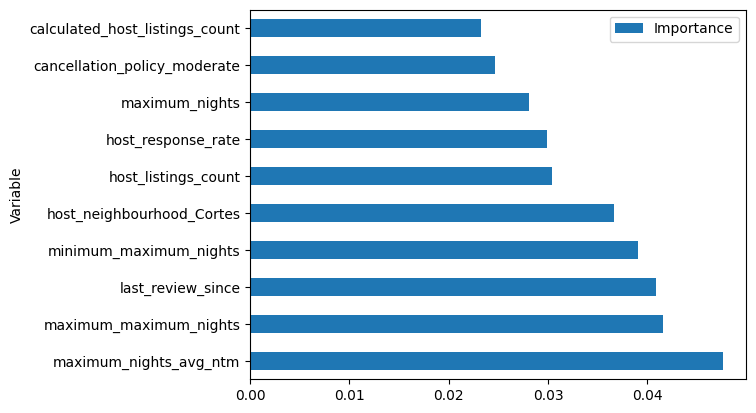

In [75]:
importance = Extra_Rand_For.feature_importances_
imp_var_ERF = pd.concat([pd.DataFrame(listings_filt2.columns,columns=['Variable']) , pd.DataFrame(importance,columns=['Importance'])] , axis=1 )
imp_var_ERF.sort_values('Importance',ascending=False,inplace=True)
imp_var_ERF.head(10).plot.barh(y='Importance',x='Variable')
plt.show()

In [76]:
Grad_Boost = GradientBoostingRegressor(loss='squared_error',n_estimators=2000,max_depth=4,min_samples_split=5).fit(x_test , y_test)
y_pred = Grad_Boost.predict(x_test)

print( "R2: %.5f" % r2_score(y_test, y_pred) )
print( 'Varianza explicada: %.5f' % explained_variance_score(y_test, y_pred) ) 
print( 'Max Error Residual: %.2f' % max_error(y_test, y_pred) )
print( 'Error Absoluto Medio: %.2f' % mean_absolute_error(y_test, y_pred) ) 
print( 'Error Cuadratico Medio: %.2f' % mean_squared_error(y_test, y_pred) )
print( 'MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred) ) 
print( 'Error Absoluto Medio; %.2f' % median_absolute_error(y_test, y_pred) )


y_pred = pd.DataFrame(y_pred,columns=['y_pred'])
y_test = pd.DataFrame(y_test,columns=['y_test'])
model_GB = pd.concat([round(pd.DataFrame(y_pred,columns=['y_pred']),2) ,pd.DataFrame(y_test,columns=['y_test'])],axis=1) 

R2: 0.99989
Varianza explicada: 0.99989
Max Error Residual: 25.38
Error Absoluto Medio: 2.90
Error Cuadratico Medio: 14.94
MAPE: 0.04
Error Absoluto Medio; 2.26


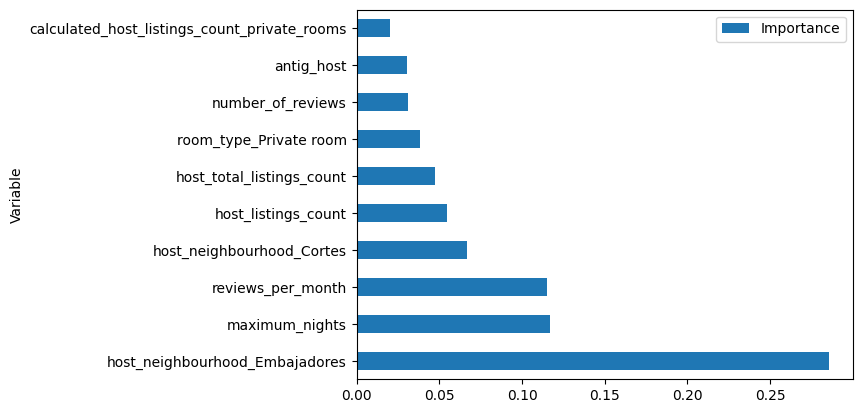

In [77]:
importance = Grad_Boost.feature_importances_
imp_var_GB = pd.concat([pd.DataFrame(listings_filt2.columns,columns=['Variable']) , pd.DataFrame(importance,columns=['Importance'])] , axis=1 )
imp_var_GB.sort_values('Importance',ascending=False,inplace=True)
imp_var_GB.head(10).plot.barh(y='Importance',x='Variable')
plt.show()

In [78]:
KN = KNeighborsRegressor(n_neighbors=5).fit(x_test, y_test)
y_pred = KN.predict(x_test)

print( "R2: %.2f" % r2_score(y_test, y_pred) )
print( 'Varianza explicada: %.2f' % explained_variance_score(y_test, y_pred) ) 
print( 'Max Error Residual: %.2f' % max_error(y_test, y_pred) )
print( 'Error Absoluto Medio: %.2f' % mean_absolute_error(y_test, y_pred) ) 
print( 'Error Cuadratico Medio: %.2f' % mean_squared_error(y_test, y_pred) )
print( 'MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred) ) 
print( 'Error Absoluto Medio; %.2f' % median_absolute_error(y_test, y_pred) )

y_pred = pd.DataFrame(y_pred,columns=['y_pred'])
y_test = pd.DataFrame(y_test,columns=['y_test'])
model_KN = pd.concat([round(pd.DataFrame(y_pred,columns=['y_pred']),2) ,pd.DataFrame(y_test,columns=['y_test'])],axis=1) 

R2: 0.56
Varianza explicada: 0.56
Max Error Residual: 6828.00
Error Absoluto Medio: 50.62
Error Cuadratico Medio: 58500.03
MAPE: 0.59
Error Absoluto Medio; 22.40


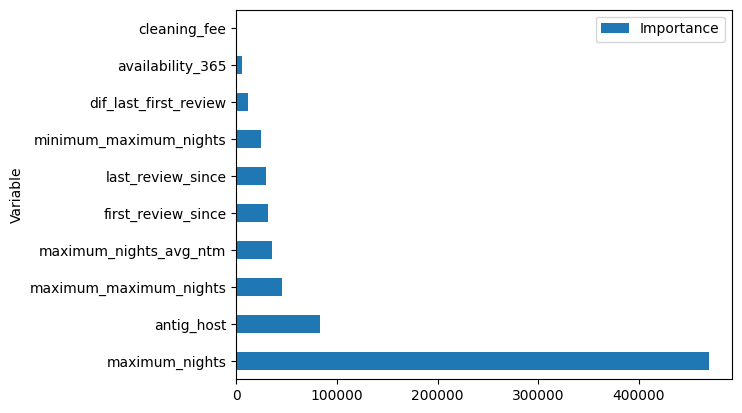

In [79]:
results = permutation_importance(KN, x_test, y_test, scoring='neg_mean_squared_error')
importance = results.importances_mean
imp_var_KN = pd.concat([pd.DataFrame(listings_filt2.columns,columns=['Variable']) , pd.DataFrame(importance,columns=['Importance'])] , axis=1 )
imp_var_KN.sort_values('Importance',ascending=False,inplace=True)
imp_var_KN.head(10).plot.barh(y='Importance',x='Variable')
plt.show()

Una característica importante que deben cumplir las variables que se utilizan es la independencia entre ellas, por lo que hay que evitar las correlaciones altas entre variables explicativas. Vamos a volver a entrenar los modelos pero sacando las variables que tengan una correlación mayor al 30%.

Redujimos la cantidad de variables, se mantuvo la bondad de ajuste pero crecieron los errores cuadráticos medios. 

In [80]:

var_num = pd.DataFrame(listings_filt_bis.dtypes,columns=['tipo'])
var_num = var_num[var_num['tipo'] != 'object']
var_num.reset_index(inplace=True)
var_num = var_num[(var_num['index'] != 'id') & (var_num['index'] != 'price')]

corr_matrix=listings_filt_bis[var_num['index'].to_list()].corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.30)]
listings_filt_bis = listings_filt_bis.drop(to_drop, axis=1)

var_dum = pd.DataFrame(listings_filt_bis.dtypes,columns=['tipo'])
var_dum = var_dum[var_dum['tipo'] == 'object']
var_dum.reset_index(inplace=True)
listings_filt_bis[var_dum['index'].to_list()]
var_dum = ['host_identity_verified','host_is_superhost','instant_bookable','neighbourhood_cleansed','property_type']

var_def = pd.DataFrame(listings_filt_bis.dtypes,columns=['tipo']).reset_index()
numeric = var_def[var_def['tipo'] != 'object']
numeric = var_def[var_def['tipo'] != 'object']
numeric = numeric['index'].to_list()

var_def = numeric + var_dum 

listings_filt3 = listings_filt_bis[var_def]

listings_filt3.drop('id',axis=1,inplace=True)
listings_filt3=pd.get_dummies(listings_filt3,drop_first=True)

y = listings_filt3['price'].values
variables = listings_filt3
variables.drop(axis=1, columns= ['price'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(variables, y, test_size=0.3, random_state=10)

In [81]:
Extra_Rand_For = ExtraTreesRegressor(max_depth=25,max_features='sqrt').fit(x_test,y_test)
y_pred = Extra_Rand_For.predict(x_test)

print( "R2: %.5f" % r2_score(y_test, y_pred) )
print( 'Varianza explicada: %.5f' % explained_variance_score(y_test, y_pred) ) 
print( 'Max Error Residual: %.2f' % max_error(y_test, y_pred) )
print( 'Error Absoluto Medio: %.2f' % mean_absolute_error(y_test, y_pred) ) 
print( 'Error Cuadratico Medio: %.2f' % mean_squared_error(y_test, y_pred) )
print( 'MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred) ) 
print( 'Error Absoluto Medio; %.2f' % median_absolute_error(y_test, y_pred) )

y_pred = pd.DataFrame(y_pred,columns=['y_pred'])
y_test = pd.DataFrame(y_test,columns=['y_test'])
model_ERF = pd.concat([round(pd.DataFrame(y_pred,columns=['y_pred']),2) ,pd.DataFrame(y_test,columns=['y_test'])],axis=1) 

R2: 0.96597
Varianza explicada: 0.96597
Max Error Residual: 1726.78
Error Absoluto Medio: 23.74
Error Cuadratico Medio: 4511.04
MAPE: 0.34
Error Absoluto Medio; 15.05


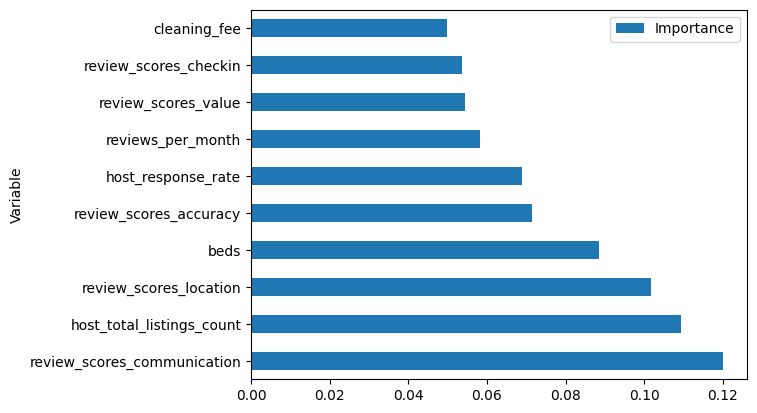

In [82]:
importance = Extra_Rand_For.feature_importances_
imp_var_ERF = pd.concat([pd.DataFrame(listings_filt2.columns,columns=['Variable']) , pd.DataFrame(importance,columns=['Importance'])] , axis=1 )
imp_var_ERF.sort_values('Importance',ascending=False,inplace=True)
imp_var_ERF.head(10).plot.barh(y='Importance',x='Variable')
plt.show()

In [83]:
Grad_Boost = GradientBoostingRegressor(loss='squared_error',n_estimators=2000,max_depth=4,min_samples_split=5).fit(x_test , y_test)
y_pred = Grad_Boost.predict(x_test)

print( "R2: %.5f" % r2_score(y_test, y_pred) )
print( 'Varianza explicada: %.5f' % explained_variance_score(y_test, y_pred) ) 
print( 'Max Error Residual: %.2f' % max_error(y_test, y_pred) )
print( 'Error Absoluto Medio: %.2f' % mean_absolute_error(y_test, y_pred) ) 
print( 'Error Cuadratico Medio: %.2f' % mean_squared_error(y_test, y_pred) )
print( 'MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred) ) 
print( 'Error Absoluto Medio; %.2f' % median_absolute_error(y_test, y_pred) )


y_pred = pd.DataFrame(y_pred,columns=['y_pred'])
y_test = pd.DataFrame(y_test,columns=['y_test'])
model_GB = pd.concat([round(pd.DataFrame(y_pred,columns=['y_pred']),2) ,pd.DataFrame(y_test,columns=['y_test'])],axis=1) 

R2: 0.99938
Varianza explicada: 0.99938
Max Error Residual: 88.42
Error Absoluto Medio: 6.30
Error Cuadratico Medio: 81.68
MAPE: 0.10
Error Absoluto Medio; 4.58


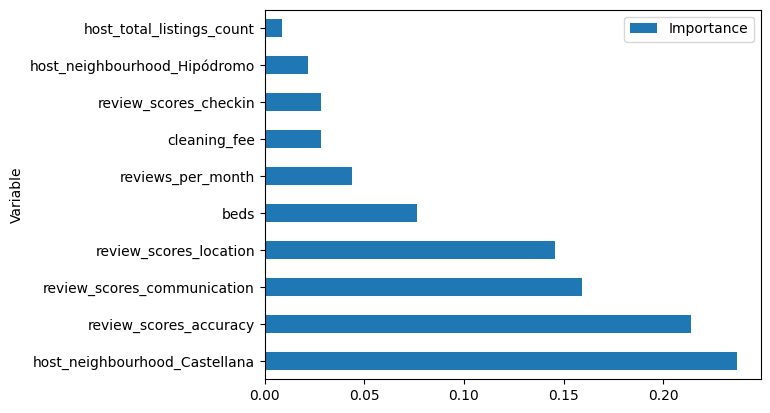

In [84]:
importance = Grad_Boost.feature_importances_
imp_var_GB = pd.concat([pd.DataFrame(listings_filt2.columns,columns=['Variable']) , pd.DataFrame(importance,columns=['Importance'])] , axis=1 )
imp_var_GB.sort_values('Importance',ascending=False,inplace=True)
imp_var_GB.head(10).plot.barh(y='Importance',x='Variable')
plt.show()

In [85]:
KN = KNeighborsRegressor(n_neighbors=5).fit(x_test, y_test)
y_pred = KN.predict(x_test)

print( "R2: %.2f" % r2_score(y_test, y_pred) )
print( 'Varianza explicada: %.2f' % explained_variance_score(y_test, y_pred) ) 
print( 'Max Error Residual: %.2f' % max_error(y_test, y_pred) )
print( 'Error Absoluto Medio: %.2f' % mean_absolute_error(y_test, y_pred) ) 
print( 'Error Cuadratico Medio: %.2f' % mean_squared_error(y_test, y_pred) )
print( 'MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred) ) 
print( 'Error Absoluto Medio; %.2f' % median_absolute_error(y_test, y_pred) )

y_pred = pd.DataFrame(y_pred,columns=['y_pred'])
y_test = pd.DataFrame(y_test,columns=['y_test'])
model_KN = pd.concat([round(pd.DataFrame(y_pred,columns=['y_pred']),2) ,pd.DataFrame(y_test,columns=['y_test'])],axis=1) 

R2: 0.53
Varianza explicada: 0.53
Max Error Residual: 6860.20
Error Absoluto Medio: 46.85
Error Cuadratico Medio: 62660.78
MAPE: 0.61
Error Absoluto Medio; 18.40


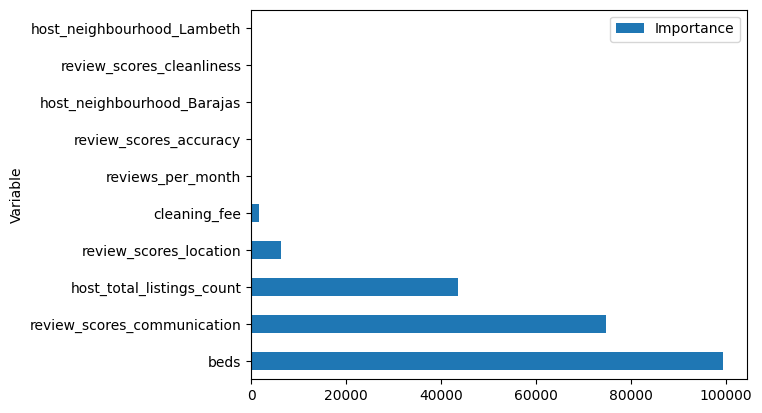

In [86]:
results = permutation_importance(KN, x_test, y_test, scoring='neg_mean_squared_error')
importance = results.importances_mean
imp_var_KN = pd.concat([pd.DataFrame(listings_filt2.columns,columns=['Variable']) , pd.DataFrame(importance,columns=['Importance'])] , axis=1 )
imp_var_KN.sort_values('Importance',ascending=False,inplace=True)
imp_var_KN.head(10).plot.barh(y='Importance',x='Variable')
plt.show()